C:\Users\arippel\AppData\Local\Temp\ipykernel_39500\1451339474.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined['mean_A_score'] = combined[score_cols].mean(axis=1)
C:\Users\arippel\AppData\Local\Temp\ipykernel_39500\1451339474.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined['age_x_mean_A'] = combined['age'] * combined['mean_A_score']
C:\Users\arippel\AppData\Local\Temp\ipykernel_39500\1451339474.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

Silhouette Score for Hierarchical Clustering: 0.7957339252291841
Davies-Bouldin Score for Hierarchical Clustering: 0.3716077119715445
Silhouette Score for KMeans: 0.6501903890065628
Davies-Bouldin Score for KMeans: 0.5031219028645647
Silhouette Score for GMM: 0.5702102079542025
Davies-Bouldin Score for GMM: 0.523658865882108
Hierarchical Cluster Summary:
                      A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  \
hierarchical_cluster                                                     
0                     0.578035  0.537572  0.468208  0.421965  0.450867   
1                     0.619048  0.761905  0.619048  0.571429  0.523810   

                      A6_Score  A7_Score  A8_Score  A9_Score  A10_Score  ...  \
hierarchical_cluster                                                     ...   
0                     0.312139  0.410405  0.543353  0.531792   0.630058  ...   
1                     0.666667  0.523810  0.619048  0.666667   0.714286  ...   

                        a

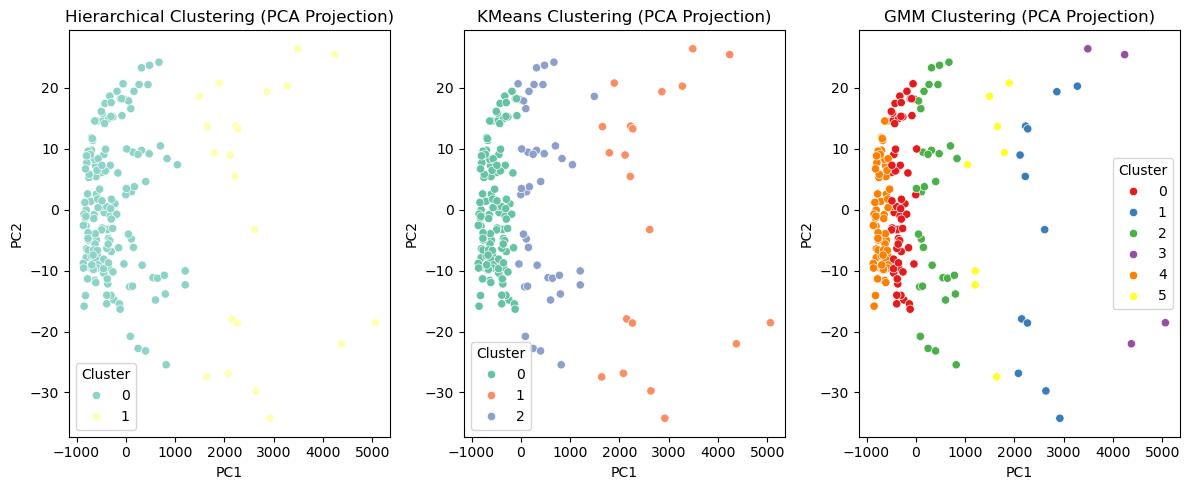

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
%run dataInfo.ipynb

cleanTest = test_df
cleanTrain = train_df #doesn't have asd/class

# Drop train class column
cleanTrain = cleanTrain.drop(columns=['Class/ASD'])
cleanTrain = cleanTrain.drop(columns=['country_of_res'])
cleanTrain = cleanTrain.drop(columns=['relation'])

# Combine train and test data for preprocessing
combined_df = pd.concat([cleanTrain, cleanTest], axis=0)
combined = combined_df.dropna()

#Engineer Composite Features

# Create a new feature 'mean_A_score' by averaging the scores of A1 to A10
score_cols = [f"A{i}_Score" for i in range(1, 11)]
combined['mean_A_score'] = combined[score_cols].mean(axis=1)

# score times age
combined['age_x_mean_A'] = combined['age'] * combined['mean_A_score']

# Polynomial features (squared terms)
combined['age_squared'] = combined['age'] ** 2
combined['mean_A_score_squared'] = combined['mean_A_score'] ** 2

#dont use scaler bc it makes it worse

# run the hierarchical clustering
model = AgglomerativeClustering(n_clusters=2, linkage='ward')  # Choose the number of clusters you want (e.g., 3)
combined['hierarchical_cluster'] = model.fit_predict(combined)
hierarchical_siloutte = silhouette_score(combined, combined['hierarchical_cluster'])
print(f"Silhouette Score for Hierarchical Clustering: {hierarchical_siloutte}")
db_hierarchical = davies_bouldin_score(combined, combined['hierarchical_cluster'])
print(f"Davies-Bouldin Score for Hierarchical Clustering: {db_hierarchical}")

#run the clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_clusters = kmeans.fit_predict(combined)
kmeans_silhouette = silhouette_score(combined, kmeans_clusters)
print(f"Silhouette Score for KMeans: {kmeans_silhouette}")
db_kmeans = davies_bouldin_score(combined, kmeans_clusters)
print(f"Davies-Bouldin Score for KMeans: {db_kmeans}")

# Let's say you want to try different cluster numbers (e.g., 3 or 4)
gmm = GaussianMixture(n_components=6, random_state=42)  # n_components is the number of clusters
gmm_clusters = gmm.fit_predict(combined)  # Fit the model and predict cluster labels
gmm_silhouette = silhouette_score(combined, gmm_clusters)
print(f"Silhouette Score for GMM: {gmm_silhouette}")
db_gmm = davies_bouldin_score(combined, gmm_clusters)
print(f"Davies-Bouldin Score for GMM: {db_gmm}")


# Add cluster labels to the combined DataFrame
combined['kmeans_cluster'] = kmeans_clusters
combined['gmm_cluster'] = gmm_clusters
combined['hierarchical_cluster'] = combined['hierarchical_cluster']

kmeans_cluster_summary = combined.groupby('kmeans_cluster').mean()
gmm_cluster_summary = combined.groupby('gmm_cluster').mean()
cluster_summary = combined.groupby('hierarchical_cluster').mean()  # Shows mean of each feature per cluster
# Print silhouette scores



#Print cluster summaries
print("Hierarchical Cluster Summary:")
print(cluster_summary)

print("KMeans Cluster Summary:")
print(kmeans_cluster_summary)

print("GMM Cluster Summary:")
print(gmm_cluster_summary)

# Reduce dimensionality
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(combined.drop(columns=['kmeans_cluster', 'gmm_cluster']))

# Convert to DataFrame
pca_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])

# Add cluster labels back in
if 'kmeans_cluster' in combined.columns:
    pca_df['kmeans_cluster'] = combined['kmeans_cluster'].values
if 'gmm_cluster' in combined.columns:
    pca_df['gmm_cluster'] = combined['gmm_cluster'].values
if 'hierarchical_cluster' in combined.columns:
    pca_df['hierarchical_cluster'] = combined['hierarchical_cluster'].values

#kmeans
plt.figure(figsize=(12, 5))

#Hierarchical
plt.subplot(1, 3, 1)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='hierarchical_cluster', palette='Set3')
plt.title('Hierarchical Clustering (PCA Projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')

# KMeans
plt.subplot(1, 3, 2)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='kmeans_cluster', palette='Set2')
plt.title('KMeans Clustering (PCA Projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')

# GMM
plt.subplot(1, 3, 3)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='gmm_cluster', palette='Set1')
plt.title('GMM Clustering (PCA Projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')

plt.tight_layout()
plt.show()



# Clustering Results Summary

## Silhouette Scores

| Clustering Method | Silhouette Score |
|-------------------|------------------|
| Hierarchical      | 0.7957           |
| KMeans            | 0.6502           |
| GMM               | 0.5702           |

- **Hierarchical Clustering** has the highest silhouette score, indicating the best-defined clusters.
- **KMeans** has a moderately high score, but not as well-defined as Hierarchical.
- **GMM** has the lowest silhouette score, suggesting it has less well-defined clusters.

---

## Hierarchical Clustering Summary

| Cluster | Mean A1 | Mean A2 | Mean A3 | Mean A4 | Mean A5 | Autism | Result | Country of Residence | Relation | Mean A Score | Age x Mean A | Age Squared | KMeans Cluster | GMM Cluster |
|---------|---------|---------|---------|---------|---------|--------|--------|----------------------|----------|--------------|--------------|-------------|----------------|-------------|
| Cluster 0 | 0.578   | 0.537   | 0.468   | 0.422   | 0.451   | 0.133  | 8.687  | 20.249               | 1.150    | 0.488        | 10.967       | 567.094     | 0.474          | 2.087       |
| Cluster 1 | 0.619   | 0.762   | 0.619   | 0.571   | 0.524   | 0.286  | 9.366  | 18.048               | 1.000    | 0.629        | 36.755       | 3516.622    | 1.048          | 2.333       |

- **Cluster 0**: Generally lower scores across all metrics, particularly in the `A` scores and relation values. This cluster might represent respondents with lower engagement or lower results.
- **Cluster 1**: Higher scores for the `A` variables and relation, with higher results. This cluster could represent more engaged or highly active respondents.

---

## KMeans Clustering Summary

| Cluster | Mean A1 | Mean A2 | Mean A3 | Mean A4 | Mean A5 | Autism | Result | Country of Residence | Relation | Mean A Score | Age x Mean A | Age Squared | Hierarchical Cluster | GMM Cluster |
|---------|---------|---------|---------|---------|---------|--------|--------|----------------------|----------|--------------|--------------|-------------|----------------------|-------------|
| Cluster 0 | 0.576   | 0.523   | 0.432   | 0.409   | 0.424   | 0.129  | 8.722  | 20.682               | 1.189    | 0.469        | 8.439        | 353.909     | 0                    | 2.121       |
| Cluster 1 | 0.600   | 0.750   | 0.600   | 0.550   | 0.550   | 0.300  | 9.277  | 17.650               | 1.000    | 0.615        | 36.399       | 3573.660    | 1                    | 2.200       |
| Cluster 2 | 0.595   | 0.595   | 0.595   | 0.476   | 0.524   | 0.143  | 8.638  | 19.024               | 1.024    | 0.560        | 19.695       | 1280.169    | 0                    | 2.048       |

- **Cluster 0**: Respondents in this cluster have lower engagement levels and results, but they come from various regions with somewhat low relation scores.
- **Cluster 1**: Respondents in this group show better results and engagement, along with higher relation and country residence scores.
- **Cluster 2**: A mix of moderately engaged individuals, slightly higher results, with age and region showing varied patterns.

---

## GMM Clustering Summary

| Cluster | Mean A1 | Mean A2 | Mean A3 | Mean A4 | Mean A5 | Autism | Result | Country of Residence | Relation | Mean A Score | Age x Mean A | Age Squared | Hierarchical Cluster | KMeans Cluster |
|---------|---------|---------|---------|---------|---------|--------|--------|----------------------|----------|--------------|--------------|-------------|----------------------|----------------|
| Cluster 0 | 0.627   | 0.567   | 0.448   | 0.403   | 0.493   | 0.150  | 8.137  | 21.239               | 1.149    | 0.496        | 11.927       | 566.786     | 0                    | 0.149          |
| Cluster 1 | 0.500   | 0.833   | 0.500   | 0.500   | 0.500   | 0.083  | 8.602  | 15.667               | 1.000    | 0.558        | 32.339       | 3354.264    | 1                    | 1              |
| Cluster 2 | 0.545   | 0.606   | 0.545   | 0.424   | 0.485   | 0.121  | 8.506  | 19.697               | 1.030    | 0.515        | 17.958       | 1241.381    | 0                    | 2              |
| Cluster 3 | 1.000   | 0.500   | 0.750   | 0.500   | 0.500   | 0.750  | 12.078 | 27.250               | 1.000    | 0.675        | 47.568       | 5173.690    | 1                    | 1              |
| Cluster 4 | 0.543   | 0.486   | 0.457   | 0.429   | 0.400   | 0.129  | 9.424  | 20.057               | 1.214    | 0.466        | 6.132        | 186.512     | 0                    | 0              |
| Cluster 5 | 0.625   | 0.625   | 0.625   | 0.750   | 0.500   | 0.250  | 7.804  | 13.500               | 1.000    | 0.688        | 33.726       | 2376.780    | 0                    | 1.5            |

- **Cluster 0**: This cluster is more focused on lower autism, with relatively lower results and country residence values. It also has moderate relation and age scores.
- **Cluster 1**: Strong engagement is shown here, especially with a higher autism score, making this group stand out in terms of results and country.
- **Cluster 2**: A balance between engagement and moderate results, with autism score, age, and country residence being prominent.
- **Cluster 3**: This group represents the most engaged, with high autism and result scores, making it unique with high relation and country scores.
- **Cluster 4**: Features moderately engaged individuals, with low to moderate autism and relation scores, pointing towards people with lower results.
- **Cluster 5**: A small, but highly engaged group with strong autism and relation scores.

---

## Latent Respondent Profiles
- **Cluster 0**: Likely represents lower-engaged respondents with basic interaction patterns.
- **Cluster 1**: Potentially highly active or engaged individuals, especially those with higher results and relations.
- **Cluster 2**: A balanced group with mixed results across scores, potentially representing a diverse range of respondent behaviors.
- **Cluster 3**: Highly engaged individuals with strong responses and relation to the cluster variables.
- **Cluster 4**: Moderate engagement with a focus on lower autism and relations.
- **Cluster 5**: Possibly a highly specific group with a stronger engagement and interaction profile.

---
